In [1]:
import torch # type: ignore

if __name__ == "__main__":
    print(torch.__version__)
    # Setup device agnostic code
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

2.3.0+cpu
Using device: cpu


In [2]:
import torch


class TinyModel(torch.nn.Module):

    def __init__(self):
        super(TinyModel, self).__init__()

        self.linear1 = torch.nn.Linear(100, 200)
        self.activation = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(200, 10)
        self.softmax = torch.nn.Softmax()

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.softmax(x)
        return x


tinymodel = TinyModel()

print('The model:')
print(tinymodel)

print('\n\nJust one layer:')
print(tinymodel.linear2)

print('\n\nModel params:')
for param in tinymodel.parameters():
    print(param)

print('\n\nLayer params:')
for param in tinymodel.linear2.parameters():
    print(param)

The model:
TinyModel(
  (linear1): Linear(in_features=100, out_features=200, bias=True)
  (activation): ReLU()
  (linear2): Linear(in_features=200, out_features=10, bias=True)
  (softmax): Softmax(dim=None)
)


Just one layer:
Linear(in_features=200, out_features=10, bias=True)


Model params:
Parameter containing:
tensor([[-0.0281, -0.0740, -0.0258,  ..., -0.0820,  0.0069,  0.0379],
        [-0.0641, -0.0269, -0.0203,  ..., -0.0015, -0.0187, -0.0585],
        [-0.0005, -0.0302, -0.0770,  ..., -0.0720, -0.0771,  0.0402],
        ...,
        [-0.0576,  0.0650, -0.0482,  ..., -0.0684, -0.0816, -0.0977],
        [ 0.0176, -0.0189, -0.0947,  ...,  0.0908,  0.0155, -0.0806],
        [ 0.0866,  0.0281,  0.0280,  ...,  0.0916,  0.0967, -0.0675]],
       requires_grad=True)
Parameter containing:
tensor([-4.1949e-02, -5.9762e-03,  6.6286e-02, -8.1473e-02, -5.8782e-02,
         6.6604e-02,  4.7256e-02,  8.8177e-02,  6.3597e-02, -7.2984e-02,
        -5.9919e-02,  1.4836e-03,  7.8904e-02, -7.8673

In [3]:
import torch.nn.functional as F


class LeNet(torch.nn.Module):

    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel (black & white), 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = torch.nn.Conv2d(1, 6, 5)
        self.conv2 = torch.nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = torch.nn.Linear(16 * 6 * 6, 120)  # 6*6 from image dimension
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [4]:
from torch import nn  # type: ignore
import torch.nn.functional as F # type: ignore


class MySmallModel(nn.Module):
    def __init__(self):
        super(MySmallModel, self).__init__()
        self.fc1 = nn.Linear(5, 2)
        self.fc2 = nn.Linear(2, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.network1 = MySmallModel()
        self.network2 = MySmallModel()
        self.network3 = MySmallModel()

        self.fc1 = nn.Linear(3, 2)
        self.fc_out = nn.Linear(2, 1)

    def forward(self, x1, x2, x3):
        x1 = F.relu(self.network1(x1))
        x2 = F.relu(self.network2(x2))
        x3 = F.relu(self.network3(x3))

        x = torch.cat((x1, x2, x3), 1)
        x = F.relu(self.fc1(x))
        x = self.fc_out(x)
        return x


model = MyModel()
N = 10
x1, x2, x3 = torch.randn(N, 5), torch.randn(N, 5), torch.randn(N, 5)

output = model(x1, x2, x3)

## Sparse Model Validation 

### Parameterisation of Feature Size and Group Feature Size

In [129]:
class GroupLayer(nn.Module):
    def __init__(self, group_feat_size: int):
        super(GroupLayer, self).__init__()
        self.fc1 = nn.Linear(group_feat_size, 1)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        return x 

class TorchModel(nn.Module):
    def __init__(self, group_feat_size: int, total_feat_size: int):
        super(TorchModel, self).__init__()
        self.group_feat_size = group_feat_size
        self.total_feat_size = total_feat_size
        num_groups = self.total_feat_size // self.group_feat_size
        # if num_groups not an integer, throw error
        if num_groups != self.total_feat_size / self.group_feat_size:
            raise ValueError("Total feature size must be divisible by group feature size")
        
        self.num_groups = num_groups
        self.group_layers = nn.ModuleList()
        i = 0 
        while i < num_groups:
            self.group_layers.append(GroupLayer(group_feat_size))
            i += 1
            
        self.layer_2_size = int(num_groups / 2)
        
        self.fc1 = nn.Linear(num_groups, self.layer_2_size)
        self.fc_out = nn.Linear(self.layer_2_size, 1)
        

    def forward(self, input_data):
        # print(input_data.shape)
        xs = []
        i = 0
        while i < self.total_feat_size:
            xs.append(input_data[:, i:i+self.group_feat_size])
            i += group_feat_size
        
        outs = []
        for i,x in enumerate(xs):
            # print(i+1, x.shape)
            outs.append(self.group_layers[i](x))

        x = torch.cat(outs, 1)
        x = F.relu(self.fc1(x))
        x = self.fc_out(x)
        return x
    

group_feat_size = 10
total_feat_size = 260

model = TorchModel(group_feat_size, total_feat_size)
N = 10
x = torch.randn(N, total_feat_size)
output = model(x)
print(output)
print(model)

tensor([[0.1208],
        [0.1936],
        [0.1864],
        [0.2696],
        [0.0661],
        [0.2202],
        [0.1334],
        [0.1326],
        [0.2051],
        [0.1475]], grad_fn=<AddmmBackward0>)
TorchModel(
  (group_layers): ModuleList(
    (0-25): 26 x GroupLayer(
      (fc1): Linear(in_features=10, out_features=1, bias=True)
    )
  )
  (fc1): Linear(in_features=26, out_features=13, bias=True)
  (fc_out): Linear(in_features=13, out_features=1, bias=True)
)


### Model Optimisation Validation 

In [177]:
# use sklearn to generate some regression data

from torch.utils.data import DataLoader
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

X, y = make_regression(n_samples=10000, n_features=260, noise=0.1)
y = y.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

train_dl = DataLoader(list(zip(X_train, y_train)), batch_size=32, shuffle=True)
test_dl = DataLoader(list(zip(X_test, y_test)), batch_size=32, shuffle=False)

In [178]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

model = TorchModel(group_feat_size, total_feat_size)


In [180]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.MSELoss()

def train(model, train_dl, optimizer, criterion, epochs=10):
    running_loss = 0.0
    for epoch in range(epochs):
        print(f"### Epoch {epoch}")
        for i, (x, y) in enumerate(train_dl):
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            print(f"Batch {i} loss: {loss.item()}")
            
    return running_loss / len(train_dl)
                            

train(model, train_dl, optimizer, criterion)

### Epoch 0
Batch 0 loss: 43265.95334051589
Batch 1 loss: 43769.70668765815
Batch 2 loss: 51063.13610698151
Batch 3 loss: 31887.078673868826
Batch 4 loss: 27212.87292946202
Batch 5 loss: 21852.101070121345
Batch 6 loss: 39404.01740497344
Batch 7 loss: 33454.19728695883
Batch 8 loss: 29582.177416267456
Batch 9 loss: 53554.742290062364
Batch 10 loss: 27230.351765344778
Batch 11 loss: 42616.03873473134
Batch 12 loss: 23140.837882220338
Batch 13 loss: 27290.00810295282
Batch 14 loss: 46852.48649854868
Batch 15 loss: 33112.50350914469
Batch 16 loss: 28583.38737521213
Batch 17 loss: 32850.4925280198
Batch 18 loss: 36527.66924541115
Batch 19 loss: 33230.5215310286
Batch 20 loss: 41223.033694636484
Batch 21 loss: 54027.38169258549
Batch 22 loss: 38549.625888154056
Batch 23 loss: 38897.8306342196
Batch 24 loss: 36914.090484084416
Batch 25 loss: 40052.6211180996
Batch 26 loss: 39344.606266426286
Batch 27 loss: 38337.501599303745
Batch 28 loss: 38634.78469499729
Batch 29 loss: 29934.59573211414
B

380638.296480749

In [137]:
# plot the output against the target

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(4, 4))
plt.scatter(y_test, output.detach().numpy())
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.title('Predicted vs True Value')
plt.show()

TypeError: forward() missing 1 required positional argument: 'input_data'

### Trying skorch

In [160]:
from skorch import NeuralNetRegressor


class GroupLayer(nn.Module):
    def __init__(self, group_feat_size: int):
        super(GroupLayer, self).__init__()
        self.fc1 = nn.Linear(group_feat_size, 1).double()

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return x


class TorchModel(nn.Module):
    def __init__(self, group_feat_size: int, total_feat_size: int):
        super(TorchModel, self).__init__()
        self.group_feat_size = group_feat_size
        self.total_feat_size = total_feat_size
        num_groups = self.total_feat_size // self.group_feat_size
        # if num_groups not an integer, throw error
        if num_groups != self.total_feat_size / self.group_feat_size:
            raise ValueError(
                "Total feature size must be divisible by group feature size")

        self.num_groups = num_groups
        self.group_layers = nn.ModuleList()
        i = 0
        while i < num_groups:
            self.group_layers.append(GroupLayer(group_feat_size))
            i += 1

        self.layer_2_size = int(num_groups / 2)

        self.fc1 = nn.Linear(num_groups, self.layer_2_size).double()
        self.fc_out = nn.Linear(self.layer_2_size, 1).double()

    def forward(self, input_data):
        # print(input_data.shape)
        xs = []
        i = 0
        while i < self.total_feat_size:
            xs.append(input_data[:, i:i+self.group_feat_size])
            i += group_feat_size

        outs = []
        for i, x in enumerate(xs):
            # print(i+1, x.shape)
            outs.append(self.group_layers[i](x))

        x = torch.cat(outs, 1)
        x = F.relu(self.fc1(x))
        x = self.fc_out(x)
        return x


group_feat_size = 10
total_feat_size = 260

net = NeuralNetRegressor(
    TorchModel,
    module__group_feat_size=group_feat_size,
    module__total_feat_size=total_feat_size,
    optimizer=torch.optim.Adam,
    criterion=torch.nn.MSELoss,
    max_epochs=10,
    lr=0.001,
    batch_size=32,
    iterator_train__shuffle=True
)



In [169]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

X, y = make_regression(n_samples=2000, n_features=260, noise=0.01)
y = y.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [170]:
net.fit(X_train, y_train)

Re-initializing module because the following parameters were re-set: group_feat_size, total_feat_size.
Re-initializing criterion.
Re-initializing optimizer.


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1    25136.4242    28184.4529  0.2992
      2    25131.6008    28180.9656  0.4549
      3    25123.8036    28172.6188  0.2994
      4    25107.4279    28155.9001  0.3518
      5    25076.7573    28121.9955  0.3075
      6    25019.4746    28054.9637  0.3289
      7    24920.8820    27951.3269  0.3097
      8    24765.2670    27787.6675  0.3423
      9    24534.5411    27549.5329  0.4599
     10    24206.8254    27207.2966  0.3357


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=TorchModel(
    (group_layers): ModuleList(
      (0-25): 26 x GroupLayer(
        (fc1): Linear(in_features=10, out_features=1, bias=True)
      )
    )
    (fc1): Linear(in_features=26, out_features=13, bias=True)
    (fc_out): Linear(in_features=13, out_features=1, bias=True)
  ),
)

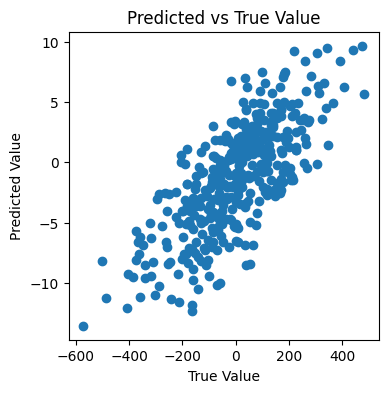

In [171]:
# make prediction 

y_pred = net.predict(X_test)

# plot the output against the target

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(4, 4))
plt.scatter(y_test, y_pred)
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.title('Predicted vs True Value')
plt.show()

## Data Integration Validation 

In [172]:
import os

import numpy as np
import pandas as pd

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find('project')
# slice the path from the index of 'project' to the end
project_path = path[:index_project+7]
# set the working directory
os.chdir(project_path)
print(f'Project path set to: {os.getcwd()}')
# Bring in CCLE data


Project path set to: c:\Github\ode-biomarker-project


In [173]:
from PathLoader import PathLoader
from DataLink import DataLink
path_loader = PathLoader('data_config.env', 'current_user.env')
data_link = DataLink(path_loader, 'data_codes.csv')


In [174]:
# load in original ccle data
loading_code = 'generic-gdsc-1-FGFR_0939-LN_IC50-fgfr4_ccle_dynamic_features-true-Row'
# generic-gdsc-{number}-{drug_name}-{target_label}-{dataset_name}-{replace_index}-{row_index}
feature_data, label_data = data_link.get_data_using_code(loading_code)

In [175]:
# convert to numpy
feature_data_numpy = feature_data.to_numpy()
label_data_numpy = label_data.to_numpy()

In [176]:
feature_data_numpy.shape

(665, 260)